# QAA to solve a MWIS problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pulser
import pulser_simulation
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform, euclidean

## Introduction

In this tutorial, we illustrate how to solve a Maximally Weighted Independent Set (MWIS) problem using an ensemble of Rydberg atoms in analog mode.

MWIS arise in many applications, including resource allocation, scheduling and staffing problems, error-correcting coding, complex system analysis and optimization, logistics and transportation, communication networks...

In the MWIS problem, we consider an undirected graph with nodes and edges where each node is associated with a positive weight. The problem is to find a maximum weighted independent set, i.e., select a set of nodes in graph where:
- there is no edge between any pair of selected nodes.
- the sum of the weights of the nodes for this set is maximised.

<div class="alert alert-info">

**Note**:

Without the second constraint, or equivalently, if all the weights of the nodes are the same, then this problem is called the Maximally Independent Set (MIS).

</div>

### Example of an MWIS

Suppose we are given the following graph:

<center>
<img src="../files/mwis_graph.png" alt="AF Pulse Sequence" width="300">
</center>

It is an undirected graph with:
- 4 nodes 0, 1, 2 and 3;
- edges between nodes 0-1, 0-2, 0-3 and 3-2;
- a weight of 2 assigned to nodes 1 and 2, and a weight of 0 assigned to nodes 0 and 3.

There are two Maximally Independent Set (sets of nodes with no edge between them):
- {1, 2}: the sum of the weights of the nodes is 4.
- {1, 3}: the sum of the weights of the nodes is 0.

So **the MWIS of this graph is {1, 2}**.

### Mathematical representation of a MWIS

Mathematically, a graph is represented by its [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix) $Q$, a symmetric matrix $Q$ of size $(N \times N)$, with $N$ the number of nodes in the graph:

In [2]:
Q = np.array(
    [
        [0, 1, 1, 1],
        [1, 2, 0, 0],
        [1, 0, 2, 1],
        [1, 0, 1, 0],
    ]
)

The optimization problem associated with the MWIS is to find the bitstring $z=(z_1, \dots, z_N) \in \{0, 1 \}^N$ that maximizes the quantity
$$f(z) = \sum_i Q_{ii} z_i$$
under the constraint, for $i\ne j$, 
$$Q_{ij}z_i + Q_{ij}z_j \le 1$$

For the above graph, the optimal solution for the MWIS problem is `0110`.

<div class="alert alert-info">

**Note**:

Under the constraint $Q_{ij}\left(z_i + z_j\right) \le 1$ for $i\ne j$, the cost function $g(z) = z^T Q z$ is also a valid cost function, because:
- $g(z)= \sum_i \sum_j Q_{ij} z_i z_j$ becomes $g(z) = \sum_i Q_{ii} z_i^2$, since the condition yields that for $i\ne j$, if $Q_{ij}\ne0$ then either $z_i=0$ or $z_j=0$ (for $i\ne j$, $Q_{ij}$ is either $0$ or $1$);
- $g(z) = \sum_i Q_{ii} z_i^2 = \sum_i Q_{ii} z_i = f(z)$ because $z_i$ is either 0 or 1.

This cost function $g$ is the same as the one used when [solving a QUBO](./qubo.nblink), except that we want here to maximize it instead of minimizing it in the case of the QUBO.
</div>

## Solving the MWIS with `Pulser` 

Let's recall that Pulser enables you to program a [Weighted Analog Ising Hamiltonian](../extended_usage_intro.md#weighted-analog-quantum-computing) $H_Q$:

$$\frac{H_Q}{\hbar}(t) = \sum_{k=1}^N \left (\frac{\Omega(t)}{2} e^{-i\phi(t)} |g\rangle\langle r|_k + \frac{\Omega(t)}{2} e^{i\phi(t)} |r\rangle\langle g|_k - (\delta(t)\mathbf{+\epsilon_k\delta_{DMM}(t)}) |r\rangle\langle r|_k + \sum_{j<k}\frac{C_6}{\hbar R_{kj}^6} \hat{n}_k \hat{n}_j \right)
$$


The first idea is to encode the off-diagonal terms of $Q$ by using the [Rydberg interaction](../programming.md#ising-hamiltonian) between atoms: 
$$\left[\frac{C_6}{\hbar R_{kj}^6}\right]_{1\leq k, h \leq N}\leftrightarrow Q_{off-diagonal}$$

Since the Rydberg interaction depends on the pairwise distance between atoms $k$ and $j$, $R_{kj}$, this will define the `Register` of atoms to use in the computation.

<div class="alert alert-info">

**Note**:

We can make this mapping because our off-diagonal terms are positive as well.

</div>

The second idea is to encode the diagonal terms of $Q$ by using the weights of the [Detuning Map](./dmm.nblink) $\epsilon_k \leftrightarrow Q_{kk}$ for $1\le k\le N$.

Finally, the third idea is to find the optimal solution of the QUBO by preparing the ground-state of $H_Q$ and outputing the optimal bitstrings. There are multiple approaches to prepare the ground-state of an Hamiltonian, we will here use the Quantum Adiabatic Algorithm (QAA), that will define $\Omega(t)$, $\delta(t)$, $\delta_{DMM}(t)$.

### 1. Pick a Device

To implement the Hamiltonian $H_Q$, we need a `Device` containing a `Rydberg.Global` channel and a `DMM` object. `pulser.DigitalAnalogDevice` and `pulser.MockDevice` are examples of `Devices` that contain these two channels. For this specific use case, let's use `pulser.MockDevice` not to be limited in terms of duration.

In [3]:
device = pulser.MockDevice
device.print_specs()

-------------------------
MockDevice Specifications
-------------------------
A virtual device for unconstrained prototyping.

Register parameters:
 - Dimensions: 3D
 - Minimum distance between neighbouring atoms: 0.0 μm

Layout parameters:
 - Requires layout: No
 - Minimal number of traps: 1
 - Maximum layout filling fraction: 0.5

Device parameters:
 - Rydberg level: 70
 - Ising interaction coefficient: 5420158.53
 - XY interaction coefficient: 3700.0
 - Channels can be reused: Yes
 - Supported bases: digital, ground-rydberg, XY
 - Supported states: u, d, r, g, h
 - SLM Mask: Yes

Channels:
 - 'rydberg_global': Rydberg(addressing='Global', max_abs_detuning=None, max_amp=None, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=1, min_duration=1, max_duration=None, min_avg_amp=0, mod_bandwidth=None, custom_phase_jump_time=None, eom_config=None, propagation_dir=None)
 - 'rydberg_local': Rydberg(addressing='Local', max_abs_detuning=None, max_amp=None, min_r

### 2. Create the Register

Let's attempt a simple minimization procedure to find the optimal positions of the atoms in the Register that replicate best the off-diagonal terms of $Q$:

In [4]:
def evaluate_mapping(
    new_coords: np.ndarray, Q: np.ndarray, device: pulser.devices.Device
):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(device.interaction_coeff / pdist(new_coords) ** 6) / 4
    return np.linalg.norm(new_Q - Q)

In [5]:
costs = []
np.random.seed(0)
x0 = np.random.random(len(Q) * 2)
res = minimize(
    evaluate_mapping,
    x0,
    args=(~np.eye(Q.shape[0], dtype=bool) * Q, device),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))

We can then build the `Register` from the obtained coordinates:

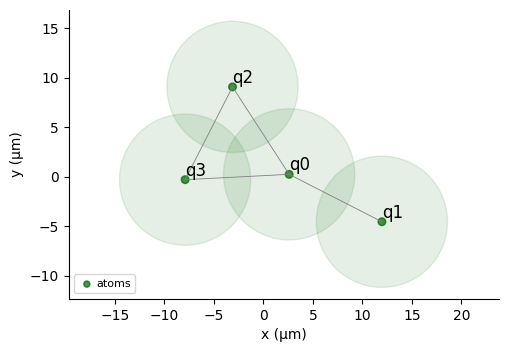

In [6]:
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = pulser.Register(qubits)
reg.draw(
    blockade_radius=device.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
)

Let's check that this register respects the device's constraints by initializing the `Sequence`: 

In [7]:
sequence = pulser.Sequence(reg, device)

<div class="alert alert-warning">

**Warning**

This optimizer approach will not work for all the graphs. You can change the optimizer to improve it but it is a simple heuristic and should not be considered as an universal encoder. 

</div>


### 3. Pick the channels

#### One Global Rydberg channel

The first channel needed to implement the Ising Hamiltonian $H_Q$ is the `Rydberg.Global` channel. Let's declare this channel in the `Sequence`:

In [8]:
sequence.declare_channel("rydberg_global", "rydberg_global")

<div class="alert alert-info">

**Note**:

At this point, the `Sequence` implements the Ising Hamiltonian:

$$\sum_{k=1}^N \left(\frac{\Omega(t)}{2} e^{-i\phi(t)} |g\rangle \langle r|_k + \frac{\Omega(t)}{2} e^{i\phi(t)} |r\rangle\langle g|_k - \delta(t) |r\rangle\langle r|_k(t) + \sum_{j<k}\frac{C_6}{\hbar R_{kj}^6} \hat{n}_k \hat{n}_j \right)
$$

</div>

#### One Detuning Map Modulator

The second channel needed to implement the Weighted Analog Ising Hamiltonian $H_Q$ is the [DMM channel](./dmm.nblink), that adds the terms 
$\sum_{1\le k\le N}\mathbf{\epsilon_k\delta_{DMM}(t)} |r\rangle\langle r|_k$ to the Ising Hamiltonian.

When configuring the `DMM` channel, we need to provide it a `DetuningMap`, which assigns to each atom in the Register a weight $\left[\epsilon_k\right]_{1\le k \le N}$.

Using the **diagonal of the matrix $Q$**, we decide that:
- the atoms that have the highest weight will not experience any additionnal detuning $\delta_{DMM}$ (we want to favor the solution for the maximal weights).
- each of the other atoms will experience an additionnal detuning, that is proportional to the difference between the highest weight and their weight.


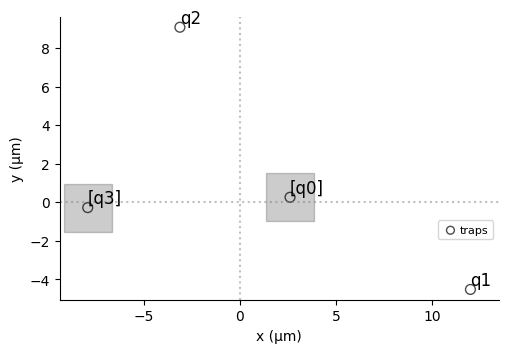

In [9]:
node_weights = np.diag(Q)
norm_node_weights = node_weights / np.max(node_weights)
det_map_weights = 1 - norm_node_weights
det_map = reg.define_detuning_map(
    {f"q{i}": det_map_weights[i] for i in range(len(det_map_weights))}
)
det_map.draw(labels=reg.qubit_ids)

Let's now configure the `DMM` using this `DetuningMap`:

In [10]:
sequence.config_detuning_map(det_map, "dmm_0")

<div class="alert alert-info">

**Note**:

If we wanted to favor the lowest diagonal terms instead of the highest (as in the case of a [QUBO](./qubo.nblink) with diagonal terms), we would have decided that:
- the atoms that have the lowest weight will not experience any additionnal detuning $\delta_{DMM}$.
- each of the other atoms will experience an additionnal detuning, that is proportional to the difference between their weight and the lowest weight.

</div>

### 4. Add the Pulses

The idea behind the adiabatic algorithm (see [Albash, Lidar, 2018](https://arxiv.org/pdf/1611.04471.pdf)) is to slowly evolve the system from an easy-to-prepare groundstate to the groundstate of $H_Q$. If done slowly enough, the system of atoms stays in the instantaneous ground-state.

In our case, we continuously vary the parameters $\Omega(t), \Delta_k(t)=\delta(t)+\epsilon_k \delta_{DMM}(t)$ (for $1\le k\le N$) in time, starting with $\Omega(0)=0, \Delta_k(0)\le0$ (for all $k$) and ending with $\Omega(0)=0, \Delta_k\ge0$ (for all $k$). The ground-state of $H(0)$ corresponds to the initial state $|gggg\rangle$ and the ground-state of $H(t_f)$ corresponds to the ground-state of $H_Q$.

To favor the final ground-state to be in an optimal solution of the MWIS, we will add a penalty detuning to the qubits associated with the lowest weights by adding a constant local detuning $\delta_{DMM}(t) = - \delta_f$.

To ensure that we are not exciting the system to states that are too excited, we keep $\Omega \in [0, \Omega_{\text{max}}]$, and choose $\Omega_{\text{max}}$ as the maximum energy of two non-connected nodes to ensures that the adiabatic path is efficient.

In [11]:
# Compute the maximum interaction between two non-connected atoms
distance_non_connected = []
for i in range(1, Q.shape[0]):
    for j in range(i - 1):
        if Q[i, j] == 0:
            distance_non_connected.append(
                euclidean(reg.qubits[f"q{i}"], reg.qubits[f"q{j}"])
            )
Omega = device.interaction_coeff / np.min(distance_non_connected) ** 6 * 10
delta_0 = -Omega  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 40000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

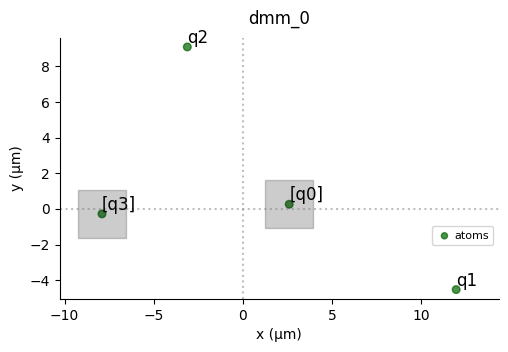

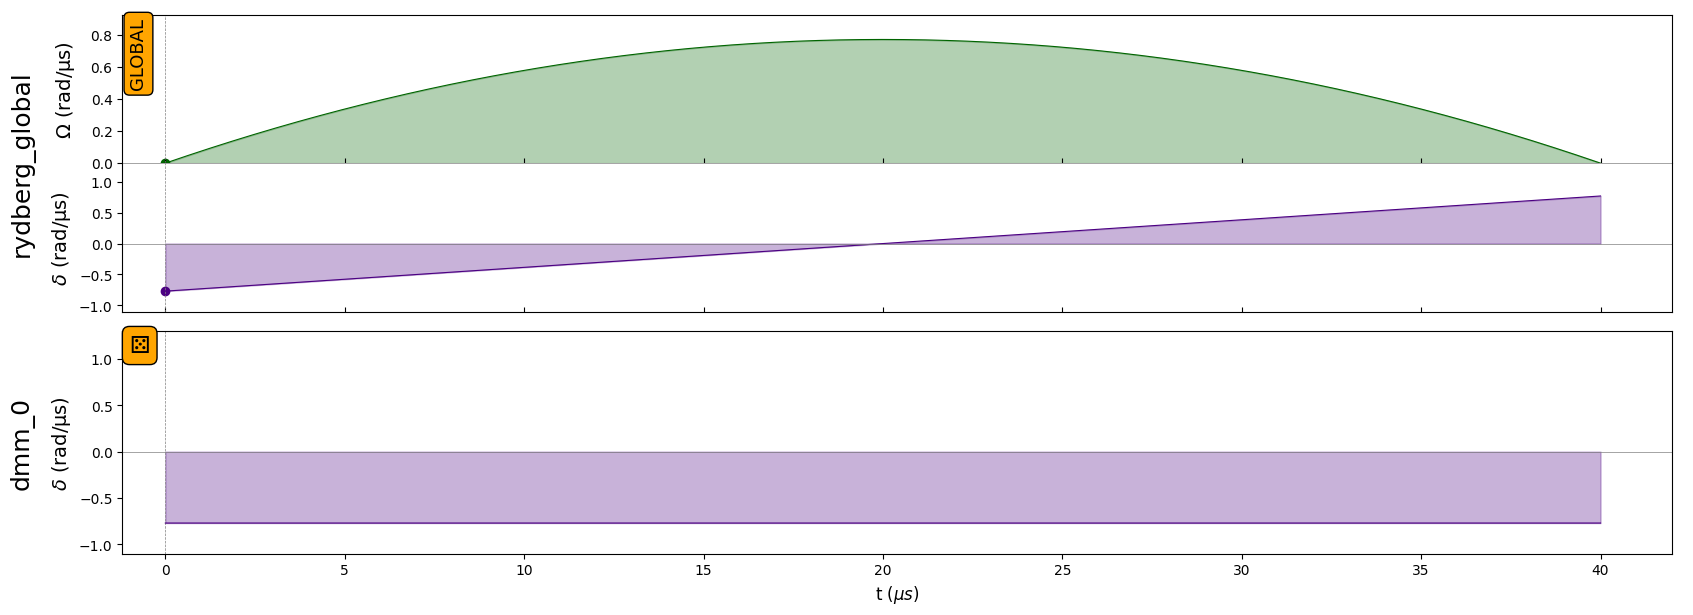

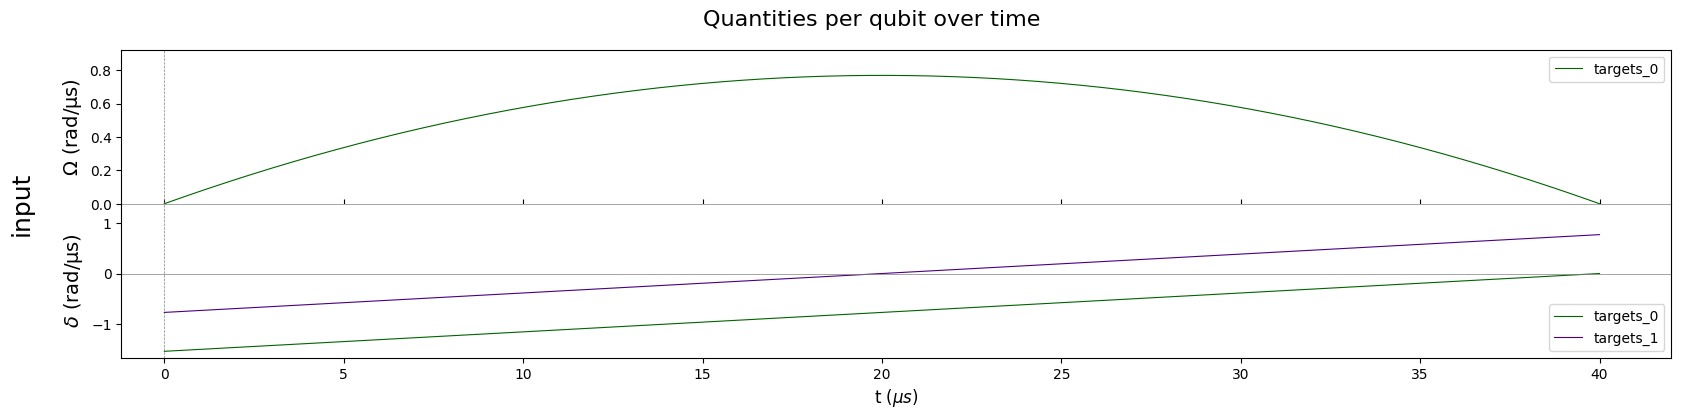

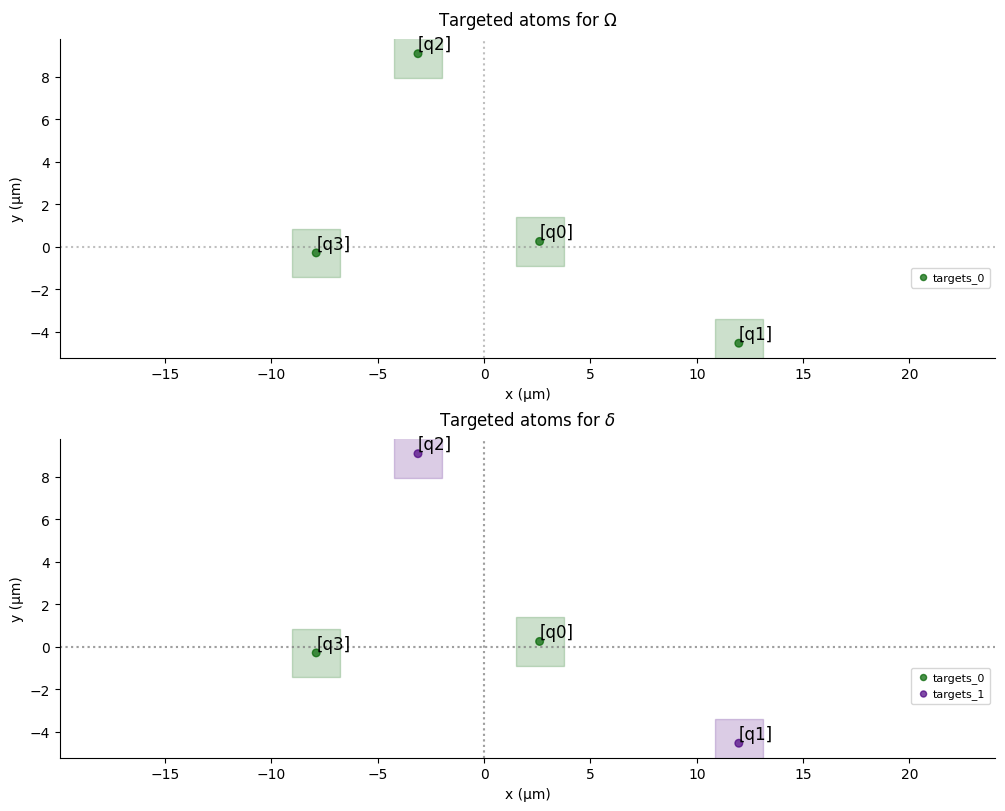

In [12]:
# Adiabatic pulse added to the Rydberg Global
adiabatic_pulse = pulser.Pulse(
    pulser.InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    pulser.InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
sequence.add(adiabatic_pulse, "rydberg_global")
# Constant pulse added to the DMM
sequence.add_dmm_detuning(pulser.ConstantWaveform(T, -delta_f), "dmm_0")
sequence.draw(
    draw_detuning_maps=True,
    draw_qubit_det=True,
    draw_qubit_amp=True,
)  # ,fig_name= "no_final_amplitude.pdf"

In [13]:
simul = pulser_simulation.QutipBackend(sequence)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

In [14]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ["0110"]  # best solution
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

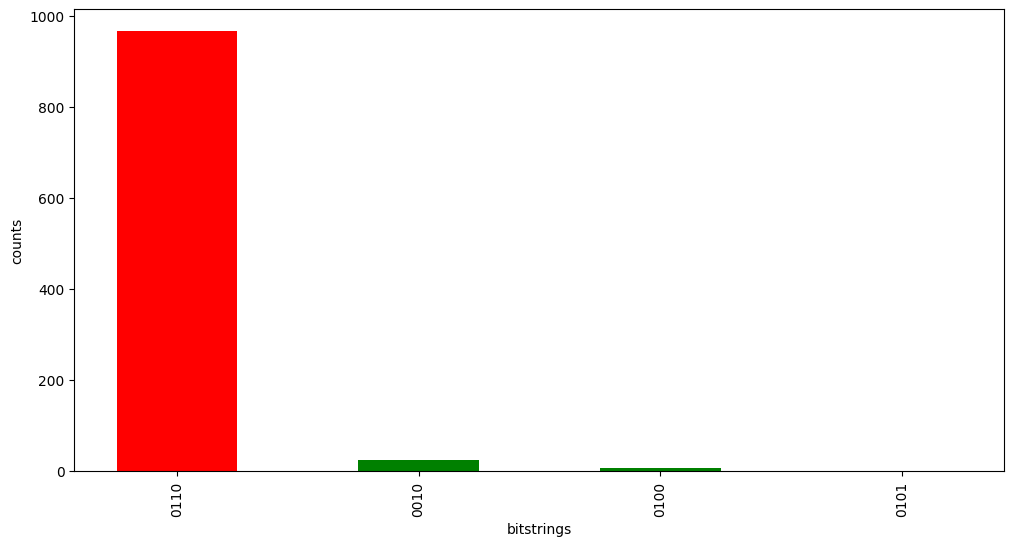

In [15]:
plot_distribution(count_dict)

The outcome is effectively `0110`, which is the optimal solution for the MWIS problem on the graph !

<div class="alert alert-info">

**To go further**:

- The heuristic we are using here to define the values of $\Omega$, $\delta$, $\delta_{DMM}$ along time works well in this case. You will surely have to adapt these values if you change the graph (the matrix $Q$). To tune them automatically, you can use an optimization procedure to find the sequence maximizing your cost function $f(z)$. An example of an optimization procedure is presented in [this tutorial](./optimization.nblink) (for a different cost function).
- This notebook can be adapted to solve a [QUBO](./qubo.nblink) with diagonal terms, only the definition of the detuning map has to be changed.
</div>